# Final Submission

This notebook contains my final submission to Kaggle's 'Time Series Forecasting' datathon. Here, we are given 3 years of data across 55 different stores based in Ecuador covering 30 product types. Test data is the final 2 weeks in August 2017.

Most of the feature engineering is somewhat basic, utilising lags of 7, 14 and 28 days, and adding a feature which is average sales across any given product group. Most of the progress was made by only training on 1 year of data before the test period, and removing 1 month of data from the training set which followed a significant earthquake that struck the region. International relief efforts following the quake seemed to add a very noisy period into the training data, and the model does better without this. 

As this is intended to train on the full dataset, we do not split our training set into training and validation groups. That split, along with the training log and hyperparameter tuning, can be found in Attempt.ipynb. Feature importance plot can be found at the bottom of the notebook.

Currently, this submission is ranked 93 / 768 with a RMSLE of 0.426, vs first place with 0.378. Possible advancements could include a more accurate treatment of local holidays (these were just ignored for ease), and incorporating regularisation parameters into the grid search.

### Packages and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error as rmsler

In [2]:
Holidays = pd.read_csv('Data/holidays_events.csv', 
                       parse_dates=['date'], 
                       index_col=['date'])
Oil_prices = pd.read_csv('Data/oil.csv', 
                       parse_dates=['date'], 
                       index_col=['date'])
Stores = pd.read_csv('Data/stores.csv')
Test = pd.read_csv('Data/test.csv',
                       parse_dates=['date'],  
                       index_col=['id'])
Train = pd.read_csv('Data/train.csv',
                       parse_dates=['date'],  
                       index_col=['id'])
Transactions = pd.read_csv('Data/transactions.csv',
                       parse_dates=['date'], 
                       index_col=['date'])   

In [3]:
training_start = "2016-01-02"
testing_start = "2017-08-16"
All_data = pd.concat([Train, Test], ignore_index=True)

### Useful Functions

In [4]:
def day_feature_engineering(df):
    """ 
    Add in  day, week, month and day of week features
    """
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [5]:
def add_lag_features(df, lags):
    """ 
    Fill missing values in the lagged columns with values from the corresponding lag column
    It is inelegant, but we have to do this twice to fill the full region of consideration 
    This actually uses the assumption that the sales in 7 days is exactly the same as today. 
    This is clearly flawed, but given the predictive power of the 7 day lag, this seems fair.
    """
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df['sales'].shift(lag)
        df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df[f'lag_{lag}'].shift(lag))
        df[f'lag_{lag}'] = df[f'lag_{lag}'].fillna(df[f'lag_{lag}'].shift(lag))
    return df

In [6]:
def target_encode_family_to_integer(df):
    """ 
    Target encoding all entires in the family column
    """
    unique_families = sorted(df['family'].unique())
    family_to_integer = {family: idx for idx, family in enumerate(unique_families)}

    df['family'] = df['family'].map(family_to_integer)    
    return df

### Date Related Feature Engineering

We are told that payday occurs on the 15th and final day pf every month. We incorporate this as a new feature column.

In [7]:
last_day_of_month_tr = All_data['date'] + pd.offsets.MonthEnd(0)
All_data.loc[:, 'payday'] = np.where(All_data['date'].dt.day.isin([1, 15]) | (All_data['date'] == last_day_of_month_tr), 1, 0)

Date encoding is also useful as our model cannot interpret dates in the usual way. We add in a day/ week/ month feature.

In [8]:
All_data = day_feature_engineering(All_data)

The economy is also apparently very reliant on the price of oil. Hence, we include this also. 

In [9]:
All_data = All_data.merge(Oil_prices, on='date', how='left')
All_data.dcoilwtico = All_data.dcoilwtico.ffill().bfill()

National holidays coul also be useful, but they do not seem to have much predictive power. We add them in for completeness. 

In [10]:
national_hols = Holidays.loc[(Holidays['locale'] == 'National') & (~Holidays['transferred'])]
All_data['is_holiday'] = All_data.index.isin(national_hols.index).astype(int)

Later, we will remove all data which is quite old. It turns out the model generalises better if you only feed it around 18 months of data. Also, we will remove the period just after the eathquake that occured April 16th 2016.

### Mean Feature Inclusion

We add a feature which is the mean sales after the training cutoff we imposed at the start of the script. 

In [11]:
cutoff_data = All_data[All_data['date'] > training_start]

mean_sales_filtered = cutoff_data.groupby(['store_nbr', 'family']).sales.mean().reset_index()
mean_sales_filtered.rename(columns={'sales': 'sales_mean'}, inplace=True)

All_data = pd.merge(All_data, mean_sales_filtered, on=['store_nbr', 'family'], how='left')

### Relational Feature Inclusion 

In [12]:
group_dfs = []
lags = [7, 14, 28]
sorted_df = All_data.sort_values(by = ['store_nbr', 'family'])

In [13]:
for (store_nbr, family), group_df in sorted_df.groupby(['store_nbr', 'family']):
    group_df_with_lags = add_lag_features(group_df, lags)
    group_dfs.append(group_df_with_lags)

In [14]:
processed_df = pd.concat(group_dfs)
pd.DataFrame(processed_df).tail(30);
df_encoded = target_encode_family_to_integer(processed_df)

### Model Training 

In [15]:
train_data_w_quake = df_encoded.loc[(df_encoded['date'] > training_start) & (df_encoded['date'] < testing_start)]
train_data = train_data_w_quake.loc[~((train_data_w_quake['date'] >= "2016-04-16") & (train_data_w_quake['date'] <= "2016-05-16"))]
test_data = df_encoded.loc[df_encoded['date'] >= testing_start]

In [22]:
features = ['store_nbr', 'family', 'onpromotion',  'dcoilwtico', 'day', 'month',  
            'sales_mean', 'lag_7', 'lag_14', 'lag_28'] # removed 'year', 'dayofweek', 'is_holiday', 'payday',
target = 'sales'

In [23]:
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

train_dataset = lgb.Dataset(X_train, label=y_train)
test_dataset = lgb.Dataset(X_test, label=y_test)

In [24]:
params = {
    'objective': 'tweedie',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_child_samples': 20,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 2
}
model = lgb.train(params,
                  train_dataset,
                  num_boost_round=1000,
                  valid_sets=[train_dataset])

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.118534
[LightGBM] [Debug] init for col-wise cost 0.000011 seconds, init for row-wise cost 0.046841 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1640
[LightGBM] [Info] Number of data points in the train set: 996138, number of used features: 10
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 6.122955
[LightGBM] [Debug] Re-bagging, using 797120 data to train
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] 

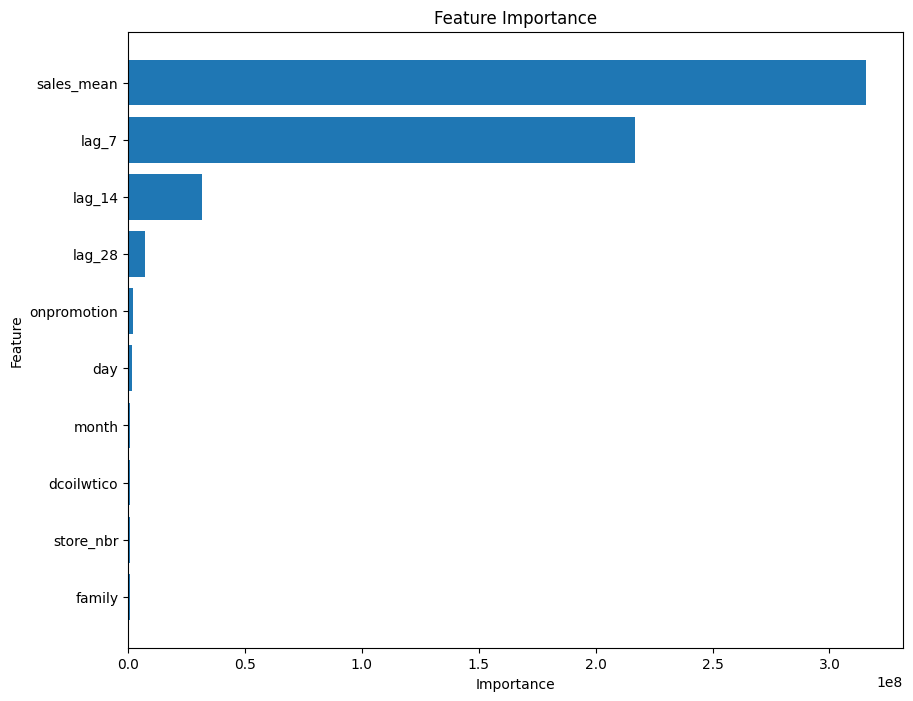

In [25]:
importance = model.feature_importance(importance_type='gain')  # or 'gain'
feature_names = model.feature_name()
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
})

# Sort the dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### Submission

In [26]:
y_test_pred = pd.DataFrame(model.predict(X_test, num_iteration=model.best_iteration), columns=['sales'], index=y_test.index)

y_test_pred = y_test_pred.rename_axis('id')
y_test_pred.to_csv('Submission3.csv')